In [1]:
from datetime import datetime
import settings.config_movie_lens as cfg
import pandas as pd
import numpy as np


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
individual_rs_strategy = cfg.individual_rs_strategy
aggregation_strategies = cfg.aggregation_strategies
recommendations_number = cfg.recommendations_number
individual_rs_validation_folds_k = cfg.individual_rs_validation_folds_k
group_rs_evaluation_folds_k = cfg.group_rs_evaluation_folds_k
evaluation_strategy = cfg.evaluation_strategy
metrics = cfg.metrics
group_types = cfg.group_types

display(cfg.dataset_folder,cfg.preprocessed_dataset_folder)

'ml-1m'

'preprocessed_dataset'

In [2]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")

import pickle

group_composition = pickle.load(open(preprocessed_dataset_folder+"/group_composition.pkl", "rb"))

ratings_df

,user,item,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
942220,6040,1091,1
942221,6040,1094,5
942222,6040,562,5
942223,6040,1096,4


## Train individual RS / Prepare groundtruth

In [3]:
# import pickle
# import os
# from individual_rs.individual_rs import IndividualRS
# from utils.utility_functions import create_per_user_group_choices

# import warnings
# warnings.filterwarnings('ignore')
# # General pipeline

# # creating train-test folds
# # split stratified on the users 

# from sklearn.model_selection import StratifiedKFold
# import itertools

# if group_types == "SYNTHETIC":
#     print(datetime.now(), "Creating folds")
#     # skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=None, shuffle=True)
#     skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=42, shuffle=True)

#     print(datetime.now(), "Folds created!")
#     current_fold = 0
#     for train_index, test_index in skf.split(ratings_df, ratings_df['user']):
#         print(">>> Start processing fold: Train", len(train_index), "Test:", len(test_index))

#         # split train and test df
#         train_df = ratings_df.iloc[train_index]
#         test_df = ratings_df.iloc[test_index]

#         # getting user-items pairs in the training set
#         train_set_pairs = set(list(zip(train_df['user'].values,train_df['item'].values)))

#         # create test_complete_df with all the possible user-items pairs in the test_df
#         user_set = set(test_df['user'].values)
#         item_set = set(test_df['item'].values)
#         all_ui_values = list(itertools.product(user_set, item_set))
#         test_pred_df = pd.DataFrame(all_ui_values, columns=['user', 'item'])

#     #     print(datetime.now(), "Extended test df")
#     #     display(test_pred_df)

#         print(datetime.now(), "Train individual RS and get predictions")
#         # train individual rs and get predictions
#         test_pred_df = IndividualRS.train_individual_rs_and_get_predictions(train_df, test_pred_df)

#         #correction for train set records (assuming repeated recommendations provide no value, therefore predicted_rating=0)
#         train_set_pairs = train_set_pairs.intersection(set(all_ui_values))
#         test_pred_df.set_index(["user","item"], inplace=True)
#         test_pred_df.loc[train_set_pairs,"predicted_rating"] = 0.0
#         test_pred_df.reset_index(inplace=True)

#         path_to_fold = preprocessed_dataset_folder+"/fold_"+str(current_fold)

#         if not os.path.exists(path_to_fold):
#             os.mkdir(path_to_fold)

#         pickle.dump(train_df, open(path_to_fold+"/train_df.pkl", "wb"))
#         pickle.dump(test_df, open(path_to_fold+"/test_df.pkl", "wb"))
#         pickle.dump(test_pred_df, open(path_to_fold+"/test_pred_df.pkl", "wb"))

#         current_fold = current_fold + 1

# else:
#     print("ERROR: incorrect config file!")
# print(datetime.now(), "Done!")
# test_pred_df


In [4]:
path_to_fold = preprocessed_dataset_folder+"/fold_0" # only fold_0 for testing for now
test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))

test_pred_df

,user,item,predicted_rating
0,1,1,0.000000
1,1,2,4.190777
2,1,3,3.755889
3,1,4,3.612580
4,1,5,3.888539
...,...,...,...
12194755,6040,3937,2.786423
12194756,6040,3946,2.261388
12194757,6040,3948,3.462167
12194758,6040,3949,4.558693


# Create top-k restricted test_pred_df

In [5]:
if cfg.top_k > 0:
    # extract group info
    unique_users = test_pred_df['user'].unique() # get all unique users in the group_ratings df# get all unique users in test_pred_df
    test_topk_pred_df = pd.DataFrame()
    for user in unique_users: # collect top-k of each user and add to new test_topk_pred_df
        user_ratings = test_pred_df.loc[test_pred_df['user'] == user]
        selected_topk_items = user_ratings.sort_values(by="predicted_rating", ascending=False).head(cfg.top_k)
        test_topk_pred_df = test_topk_pred_df.append(selected_topk_items)
        
    pickle.dump(test_topk_pred_df, open(path_to_fold+"/test_topk_pred_df.pkl", "wb")) # dump new test_topk_pred_df to pickle file in folder
    print(test_topk_pred_df)

# Construct group recommendations

In [7]:
from utils.utility_functions import generate_group_recommendations_forall_groups

import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]
folds = ["fold_0"] # Only do fold_0, quicker testing

for f in folds:
    current_fold = int(f.replace("fold_",""))
    path_to_fold = preprocessed_dataset_folder+"/"+f
    
    if group_types == "SYNTHETIC":
        train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
        test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
        test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
        test_topk_pred_df = pickle.load(open(path_to_fold+"/test_topk_pred_df.pkl", "rb"))
    else:
        print("ERROR: incorrect config file!")     

    print(datetime.now(), f+": Generate GRS for all the aggregation strategies and all the groups")
    # - generate the recommendations for all the aggregation strategies and all the groups
    # print(group_composition)
    
    if cfg.top_k > 0:
        group_recommendations = generate_group_recommendations_forall_groups(test_topk_pred_df, group_composition, cfg.recommendations_number)
        print(datetime.now(), f+": Done")
        
        pickle.dump(group_recommendations, open(path_to_fold+"/topk_group_recommendations.pkl", "wb"))
    else:
        group_recommendations = generate_group_recommendations_forall_groups(test_pred_df, group_composition, cfg.recommendations_number)
        print(datetime.now(), f+": Done")
        
        pickle.dump(group_recommendations, open(path_to_fold+"/group_recommendations.pkl", "wb"))



2023-03-02 18:00:18.717216 fold_0: Generate GRS for all the aggregation strategies and all the groups
It reached generate_group_recommendations_forall_groups, group 0
It reached generate_group_recommendations_forall_groups, group 1
It reached generate_group_recommendations_forall_groups, group 2
It reached generate_group_recommendations_forall_groups, group 3
It reached generate_group_recommendations_forall_groups, group 4
It reached generate_group_recommendations_forall_groups, group 5
It reached generate_group_recommendations_forall_groups, group 6
It reached generate_group_recommendations_forall_groups, group 7
It reached generate_group_recommendations_forall_groups, group 8
It reached generate_group_recommendations_forall_groups, group 9
It reached generate_group_recommendations_forall_groups, group 10
It reached generate_group_recommendations_forall_groups, group 11
It reached generate_group_recommendations_forall_groups, group 12
It reached generate_group_recommendations_forall_g

# Evaluate group recommendations
### Define evaluation variants

In [8]:
evaluation_variants = [
   {
       "evaluation_strategy": "COUPLED",
       "binarize_feedback": True,
       "binarize_feedback_positive_threshold": 4.0,
       "inverse_propensity_debiasing": False,
       "inverse_propensity_gamma": 0.0
   },
#    {
#        "evaluation_strategy": "COUPLED",
#        "binarize_feedback": True,
#        "binarize_feedback_positive_threshold": 4.0,
#        "inverse_propensity_debiasing": True,
#        "inverse_propensity_gamma": 0.5
#    },
#    {
#        "evaluation_strategy": "COUPLED",
#        "binarize_feedback": False,
#        "inverse_propensity_debiasing": False,
#        "inverse_propensity_gamma": 0.0
#    },
#    {
#        "evaluation_strategy": "COUPLED",
#        "binarize_feedback": False,
#        "inverse_propensity_debiasing": True,
#        "inverse_propensity_gamma": 0.5
#    },    
]
# evaluation_variants = [
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": True,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": 0.0    
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": True,
#         "binarize_feedback_positive_threshold": 3.0,
#         "feedback_polarity_debiasing": 0.0    
#     },    
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": 0.0
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": -2.0   
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": -4.0
#     },    
# ]

In [5]:
import os
import time
import json
from utils.utility_functions import calculate_inverse_propensity_score,calculate_inverse_propensity_score_user_normalization
from utils.utility_functions import evaluate_group_recommendations_forall_groups

import warnings
warnings.filterwarnings('ignore')

lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]
folds = ["fold_0"]

for ev in evaluation_variants:
    for i in ev.keys():
        setattr(cfg, i, ev[i])

    evaluations = list()
    for f in folds:
        current_fold = int(f.replace("fold_",""))
        path_to_fold = preprocessed_dataset_folder+"/"+f
        
        if group_types == "SYNTHETIC":
            train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
            test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
            test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
            test_topk_pred_df = pickle.load(open(path_to_fold+"/test_topk_pred_df.pkl", "rb"))
        else:
            print("ERROR: incorrect config file!")  
        
        if cfg.top_k > 0:
            group_recommendations = pickle.load(open(path_to_fold+"/group_recommendations.pkl", "rb"))
        else:
            group_recommendations = pickle.load(open(path_to_fold+"/topk_group_recommendations.pkl", "rb"))

        # - evaluate the recommendations
        if cfg.evaluation_strategy == "COUPLED":
            ground_truth = test_df
        else:
            if cfg.top_k > 0:
                ground_truth = test_topk_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")
            else:
                ground_truth = test_topk_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

        if cfg.inverse_propensity_debiasing == True and cfg.evaluation_strategy == "COUPLED":
            propensity_per_item = calculate_inverse_propensity_score(ratings_df, train_df, cfg.inverse_propensity_gamma)
            per_user_propensity_normalization_term = calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df)
        else:
            #dummies to simplify downstream code
            propensity_per_item = pd.Series({"propensity_score":1.0})
            per_user_propensity_normalization_term = None

        print(datetime.now(), f+": Evaluate Group recommendations")
        # modify the evaluation code to handle change for top-k restricted items
        # also let the option of this, unchanged
        fold_group_evaluations = evaluate_group_recommendations_forall_groups(
            ground_truth, 
            group_recommendations, 
            group_composition, 
            propensity_per_item, 
            per_user_propensity_normalization_term,
            current_fold,
            cfg.evaluation_ground_truth,            
            cfg.binarize_feedback_positive_threshold,
            cfg.binarize_feedback,
            cfg.feedback_polarity_debiasing 
        )
        print(datetime.now(), "Fold Evaluation DONE")
        #display(fold_group_evaluations)

        evaluations = evaluations + fold_group_evaluations
        #current_fold = current_fold + 1
    eval_df = pd.DataFrame.from_records(evaluations)  
    
    
    
    path_to_eval_folder = preprocessed_dataset_folder+"/eval_"+str(time.time())
    eval_parameters = {key:cfg.__dict__[key] for key in cfg.__dict__.keys() if not (key.startswith('__') or key.startswith('_'))}

    if not os.path.exists(path_to_eval_folder):
        os.mkdir(path_to_eval_folder)
        
    
    pickle.dump(eval_parameters, open(path_to_eval_folder+"/eval_parameters.pkl", "wb"))    
    pickle.dump(eval_df, open(path_to_eval_folder+"/eval_df.pkl", "wb"))
    pickle.dump(group_composition, open(path_to_eval_folder+"/group_composition.pkl", "wb"))
    #for human readability
    with open(path_to_eval_folder+"/eval_parameters.json" , "w" ) as write:
        json.dump( eval_parameters , write )        

2023-02-24 10:24:45.313346 fold_0: Evaluate Group recommendations
2023-02-24 10:25:07.847052 Fold Evaluation DONE


# Show how individual evaluation runs differs from each other
- only show parameters with non-uniform values

In [12]:
import os
import time
import json
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]
list(enumerate(results))

[(0, 'eval_1677245107.8690538')]

In [13]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]

eval_params_list = []
for r in results:
    path_to_eval_folder = preprocessed_dataset_folder + "/" + r
    eval_params = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
    eval_params_list.append(eval_params)

parameters_df = pd.DataFrame(eval_params_list)
parameters_df.index = results
keep_col = []
parameters_df = parameters_df.astype(str)
for c in parameters_df.columns:
    if len(parameters_df.loc[:,c].unique()) > 1:
        keep_col.append(True)
    else:
        keep_col.append(False)
parameters_df_relevant = parameters_df.loc[:,keep_col]  
parameters_df_relevant

""
eval_1677245107.8690538


# Visualize results from individual evaluation runs

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
#select which evaluation run to display
res_folder = parameters_df.index[0]
path_to_eval_folder = preprocessed_dataset_folder + "/" + res_folder

eval_parameters = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))
group_composition = pickle.load(open(path_to_eval_folder+"/group_composition.pkl", "rb"))

In [16]:
#add / remove metrics considered for evaluation
metric_whitelist = ["NDCG","DCG","DFH","Recall","BoundedRecall","zRecall","MRR"]
eval_df = eval_df.loc[eval_df.metric.isin(metric_whitelist)]


### Depict overall (mean) results across all groups

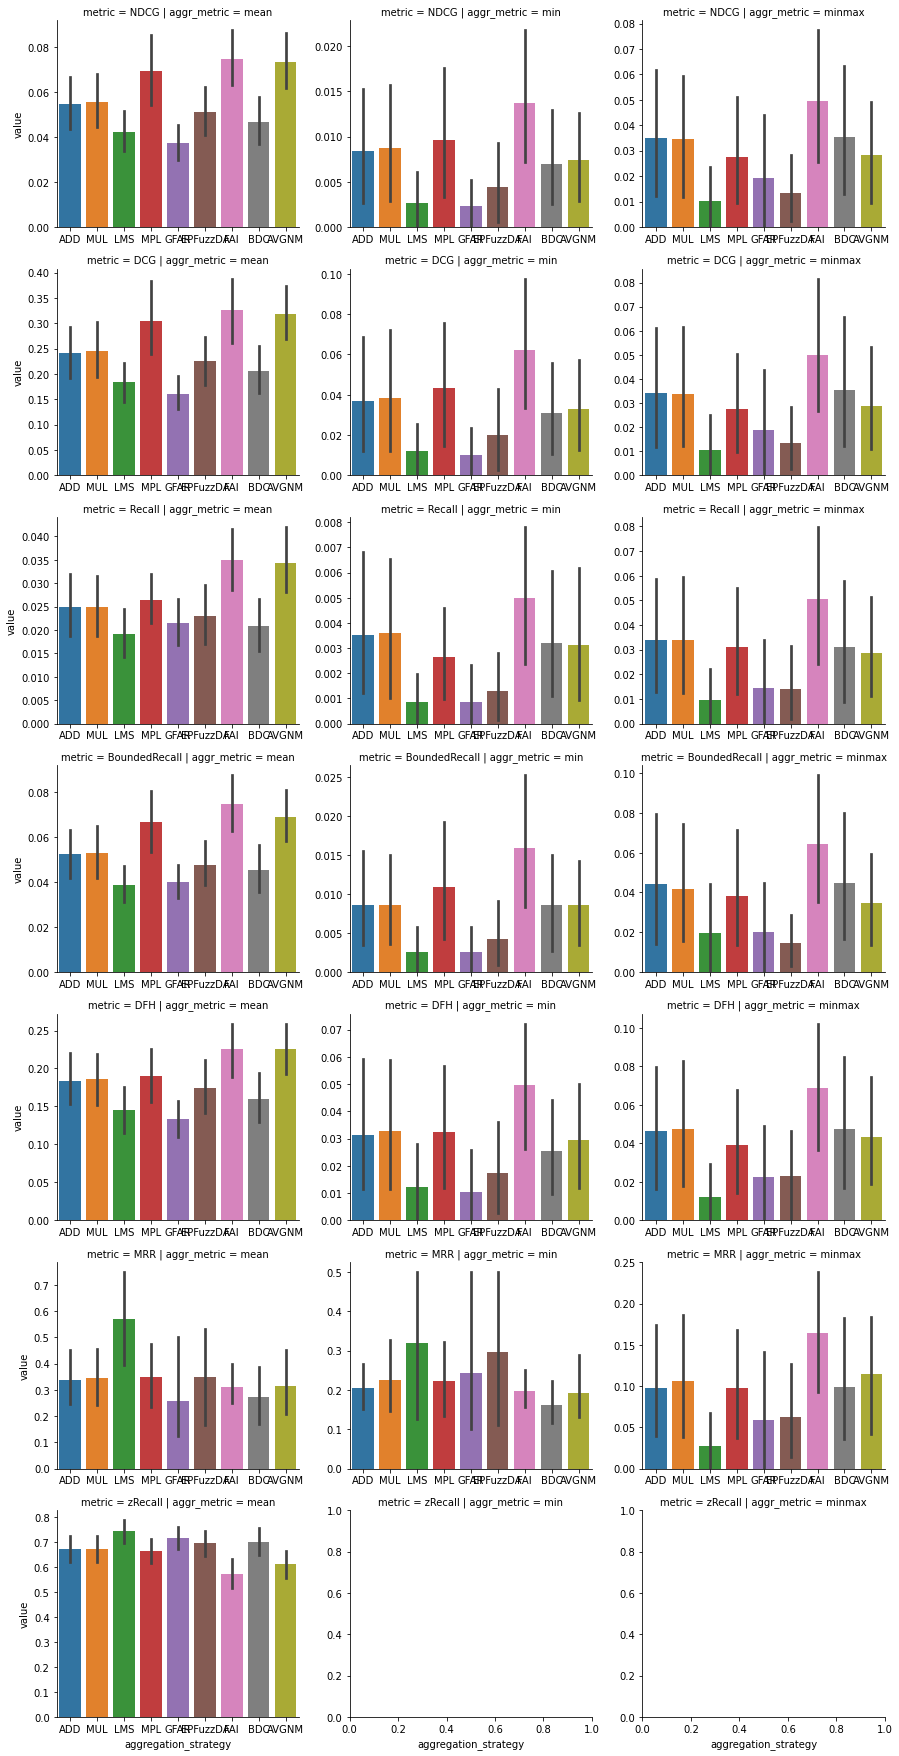

In [17]:
all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

In [19]:
group_composition_DF = pd.DataFrame(group_composition).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id"))
eval_df_with_group_info.head()

,group_size,group_similarity,group_members,metric,aggr_metric,value,aggregation_strategy,current_fold
0,2,random,"[4805, 5428]",NDCG,mean,0.047394,ADD,0
0,2,random,"[4805, 5428]",NDCG,min,0.000000,ADD,0
0,2,random,"[4805, 5428]",NDCG,minmax,0.000000,ADD,0
0,2,random,"[4805, 5428]",DCG,mean,0.215338,ADD,0
0,2,random,"[4805, 5428]",DCG,min,0.000000,ADD,0


### Metric variance per group size; keeping the aggregation strategies visible

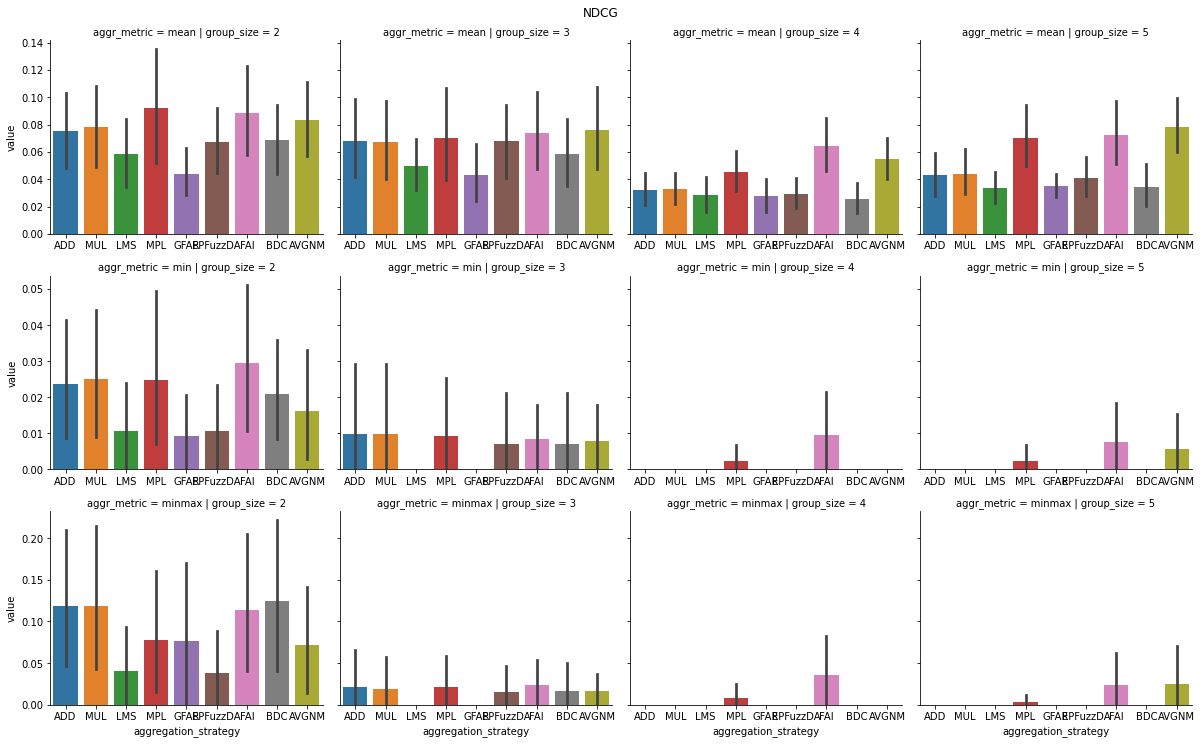

In [20]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle(metric)
plt.tight_layout()


### Metric variance per group size; merging all aggregation strategies

In [ ]:
g = sns.catplot(data=eval_df_with_group_info, row="metric", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


### Metric variance per group size and group type; merging all aggregation strategies

In [ ]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], hue="group_similarity", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)

### Depict distribution of per-group values for all metrics

In [ ]:
g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="boxen",  height=3.5, aspect=1.2)

In [ ]:
#group_folds = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy', 'group_id']).mean()
#display(group_folds['value'].reset_index().sort_values(by='group_id'))

In [ ]:
#eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().head(50)

# Compare results of multiple evaluation runs
### Collect all results and extend eval_df with relevant evaluation parameters

In [ ]:
#get all evaluation runs specified in valid_rows
def get_valid_evaluation_data(valid_rows):
    eval_df_list = []
    for res in valid_rows:
        path_to_eval_folder = preprocessed_dataset_folder + "/" + res
        eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))    
        for c in parameters_df_relevant.columns:
            eval_df[c]=parameters_df_relevant.loc[res,c]
        eval_df_list.append(eval_df)

    eval_df_concat = pd.concat(eval_df_list)
    return eval_df_concat

In [ ]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[:4]
parameters_df_relevant.loc[valid_rows]

In [ ]:
eval_df_concat = get_valid_evaluation_data(valid_rows)
eval_df_concat.head(3)

### Coupled evaluation: effect of feedback binarization and inverse propensity debiasing

In [ ]:
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="binarize_feedback_positive_threshold", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex="col", sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

In [ ]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[[1,4,5,6,7]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

In [ ]:
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric],  
                col="aggr_metric", hue="inverse_propensity_gamma", 
                x="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

In [ ]:
valid_rows = parameters_df_relevant.index[[4,5,6,7]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric],  
                col="aggr_metric", hue="inverse_propensity_gamma", 
                x="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

### Decoupled evaluation: effect of polarity debiasing

In [ ]:
valid_rows = parameters_df_relevant.index[11:15]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

In [ ]:
metric = "NDCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="feedback_polarity_debiasing", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex=False, sharey="row",
                kind="bar",  height=3.5, aspect=1.2)

In [ ]:
valid_rows = parameters_df_relevant.index[[10,15,16]]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

In [ ]:
metric = "NDCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="binarize_feedback_positive_threshold", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)